# 1_Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error
from haversine import haversine
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import mutual_info_regression

%matplotlib inline

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 78)

In [2]:
# Read in training and testing datasets

test_file = './datasets/test.csv'
train_file = './datasets/train.csv'

train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)

C:\Users\leagu\AppData\Local\Temp\ipykernel_9728\355614409.py:6: DtypeWarning: Columns (42) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(train_file)
C:\Users\leagu\AppData\Local\Temp\ipykernel_9728\355614409.py:7: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv(test_file)


In [3]:
# Imputing NaN values with 0 for Hawkers and Malls

hawker_mall_impute = ['Hawker_Within_500m','Mall_Within_500m', 'Hawker_Within_1km','Hawker_Within_2km', 'Mall_Within_1km','Mall_Within_2km']

for col in hawker_mall_impute:
    train_df[col] = train_df[col].fillna(0)
    test_df[col] = test_df[col].fillna(0)

In [4]:
# Drop rows where Mall_Nearest_Distance==NaN (Cannot drop rows in test_df)

train_df.dropna(subset=['Mall_Nearest_Distance'], inplace=True)

In [5]:
# Double-check if any more NaNs

test_df.isnull().sum().sort_values(ascending=False).head(20)
train_df.isnull().sum().sort_values(ascending=False).head(20)

id                         0
Mall_Within_2km            0
mrt_nearest_distance       0
hawker_market_stalls       0
hawker_food_stalls         0
Hawker_Within_2km          0
Hawker_Within_1km          0
Hawker_Within_500m         0
Hawker_Nearest_Distance    0
Mall_Within_1km            0
bus_interchange            0
Mall_Within_500m           0
Mall_Nearest_Distance      0
planning_area              0
Longitude                  0
Latitude                   0
postal                     0
other_room_rental          0
mrt_name                   0
mrt_interchange            0
dtype: int64

In [6]:
# Convert all columns to lowercase

train_df.columns = train_df.columns.str.lower()
test_df.columns = test_df.columns.str.lower()


# Drop price_per_sqft from dataset
train_df = train_df.drop(columns='price_per_sqft')
test_df = test_df.drop(columns='price_per_sqft')

In [7]:
# Replace 'Y' and 'N' values in these Amenities columns with 1 and 0 for counting

train_df[['market_hawker','multistorey_carpark', 'precinct_pavilion']] = train_df[['market_hawker','multistorey_carpark', 'precinct_pavilion']].replace({'Y':1, 'N':0})
test_df[['market_hawker','multistorey_carpark', 'precinct_pavilion']] = test_df[['market_hawker','multistorey_carpark', 'precinct_pavilion']].replace({'Y':1, 'N':0})

In [8]:
# Save Cleaned df 

# train_df.to_csv('./datasets/cleaned_train_set.csv', index=False)
# test_df.to_csv('./datasets/cleaned_test_set.csv', index=False)

# 2_EDA

In [9]:
# Read in cleaned training and testing datasets

train_filepath = './datasets/cleaned_train_set.csv'
test_filepath = './datasets/cleaned_test_set.csv'

train_df = pd.read_csv(train_filepath)
test_df = pd.read_csv(test_filepath)

train_df.head(10)

C:\Users\leagu\AppData\Local\Temp\ipykernel_13328\800817914.py:6: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(train_filepath)
C:\Users\leagu\AppData\Local\Temp\ipykernel_13328\800817914.py:7: DtypeWarning: Columns (40) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv(test_filepath)


,id,tranc_yearmonth,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,tranc_year,tranc_month,mid_storey,lower,upper,mid,full_flat_type,address,floor_area_sqft,hdb_age,max_floor_lvl,year_completed,residential,commercial,market_hawker,multistorey_carpark,precinct_pavilion,total_dwelling_units,1room_sold,2room_sold,3room_sold,4room_sold,5room_sold,exec_sold,multigen_sold,studio_apartment_sold,1room_rental,2room_rental,3room_rental,other_room_rental,postal,latitude,longitude,planning_area,mall_nearest_distance,mall_within_500m,mall_within_1km,mall_within_2km,hawker_nearest_distance,hawker_within_500m,hawker_within_1km,hawker_within_2km,hawker_food_stalls,hawker_market_stalls,mrt_nearest_distance,mrt_name,bus_interchange,mrt_interchange,mrt_latitude,mrt_longitude,bus_stop_nearest_distance,bus_stop_name,bus_stop_latitude,bus_stop_longitude,pri_sch_nearest_distance,pri_sch_name,vacancy,pri_sch_affiliation,pri_sch_latitude,pri_sch_longitude,sec_sch_nearest_dist,sec_sch_name,cutoff_point,affiliation,sec_sch_latitude,sec_sch_longitude
0,88471,2016-05,KALLANG/WHAMPOA,4 ROOM,3B,UPP BOON KENG RD,10 TO 12,90.0,Model A,2006,680000.0,2016,5,11,10,12,11,4 ROOM Model A,"3B, UPP BOON KENG RD",968.760,15,25,2005,Y,N,0,0,0,142,0,0,0,96,46,0,0,0,0,0,0,0,382003,1.314299,103.872828,Kallang,1094.090418,0.0,0.0,7.0,154.753357,1.0,3.0,13.0,84,60,330.083069,Kallang,0,0,1.311540,103.871731,29.427395,Blk 3B,1.314433,103.872600,1138.633422,Geylang Methodist School,78,1,1.317659,103.882504,1138.633422,Geylang Methodist School,224,0,1.317659,103.882504
1,122598,2012-07,BISHAN,5 ROOM,153,BISHAN ST 13,07 TO 09,130.0,Improved,1987,665000.0,2012,7,8,7,9,8,5 ROOM Improved,"153, BISHAN ST 13",1399.320,34,9,1987,Y,N,0,0,0,112,0,0,0,56,56,0,0,0,0,0,0,0,570153,1.346086,103.855078,Bishan,866.941448,0.0,1.0,3.0,640.151925,0.0,1.0,7.0,80,77,903.659703,Bishan,1,1,1.350580,103.848305,58.207761,BLK 151A MKT,1.345659,103.855381,415.607357,Kuo Chuan Presbyterian Primary School,45,1,1.349783,103.854529,447.894399,Kuo Chuan Presbyterian Secondary School,232,0,1.350110,103.854892
2,170897,2013-07,BUKIT BATOK,EXECUTIVE,289B,BT BATOK ST 25,13 TO 15,144.0,Apartment,1997,838000.0,2013,7,14,13,15,14,EXECUTIVE Apartment,"289B, BT BATOK ST 25",1550.016,24,16,1996,Y,N,0,0,0,90,0,0,0,0,30,60,0,0,0,0,0,0,651289,1.343867,103.760535,Bukit Batok,1459.579948,0.0,0.0,4.0,1762.082341,0.0,0.0,1.0,84,95,1334.251197,Bukit Batok,1,0,1.349561,103.749970,214.747860,Blk 289E,1.344064,103.758613,498.849039,Keming Primary School,39,0,1.345245,103.756265,180.074558,Yusof Ishak Secondary School,188,0,1.342334,103.760013
3,86070,2012-04,BISHAN,4 ROOM,232,BISHAN ST 22,01 TO 05,103.0,Model A,1992,550000.0,2012,4,3,1,5,3,4 ROOM Model A,"232, BISHAN ST 22",1108.692,29,11,1990,Y,Y,0,0,0,75,0,0,0,68,7,0,0,0,0,0,0,0,570232,1.358245,103.845504,Bishan,950.175199,0.0,1.0,4.0,726.215262,0.0,1.0,9.0,32,86,907.453484,Bishan,1,1,1.350580,103.848305,43.396521,Opp Bishan Nth Shop Mall,1.358045,103.845169,389.515528,Catholic High School,20,1,1.354789,103.844934,389.515528,Catholic High School,253,1,1.354789,103.844934
4,153632,2017-12,YISHUN,4 ROOM,876,YISHUN ST 81,01 TO 03,83.0,Simplified,1987,298000.0,2017,12,2,1,3,2,4 ROOM Simplified,"876, YISHUN ST 81",893.412,34,4,1987,Y,N,0,0,0,48,0,0,0,30,18,0,0,0,0,0,0,0,760876,1.414745,103.835532,Yishun,729.771895,0.0,1.0,2.0,1540.151439,0.0,0.0,1.0,45,0,412.343032,Khatib,0,0,1.417131,103.832692,129.422752,Blk 873,1.415424,103.836477,401.200584,Naval Base Primary School,74,0,1.416280,103.838798,312.025435,Orchid Park Secondary School,208,0,1.414888,103.838335
5,26610,2013-01,GEYLANG,3 ROOM,95,ALJUNIED CRES,07 TO 09,65.0,Improved,1975,335000.0,2013,1,8,7,9,8,3 ROOM Improved,"95, ALJUNIED CRES",699.660,46,12,1974,Y,Y,0,0,0,193,0,0,188,0,5,0,0,0,0,0,0,0,380095,1.321703,103.886196,Geylang,684.004001,0.0,3.0,6.0,148.418247,2.0,5.0,11.0,79,82,678.291272,MacPherson,0,1,1.325859,103.890663,229.680469,Blk 90,1.323622,103.886962,594.128

In [10]:
# Check cardinality of categorical features to decide how to encode them

# Get n(unique) entries in each 'object' col first
object_cols = [col for col in train_df.columns if train_df[col].dtype=='object']
object_nunique = list(map(lambda col: train_df[col].nunique(), object_cols))

d = dict(zip(object_cols, object_nunique))
sorted(d.items(), key=lambda x:x[1])


# address and postal have the most categories
# Features with >15 categories will not be OneHotEncoded and dealt with using Target Encoding

[('residential', 1),
 ('commercial', 2),
 ('flat_type', 7),
 ('flat_model', 20),
 ('storey_range', 25),
 ('town', 26),
 ('planning_area', 32),
 ('full_flat_type', 43),
 ('mrt_name', 94),
 ('tranc_yearmonth', 110),
 ('sec_sch_name', 134),
 ('pri_sch_name', 177),
 ('street_name', 547),
 ('bus_stop_name', 1637),
 ('block', 2440),
 ('address', 9015),
 ('postal', 17265)]

<AxesSubplot: title={'center': 'resale_price'}, ylabel='planning_area'>

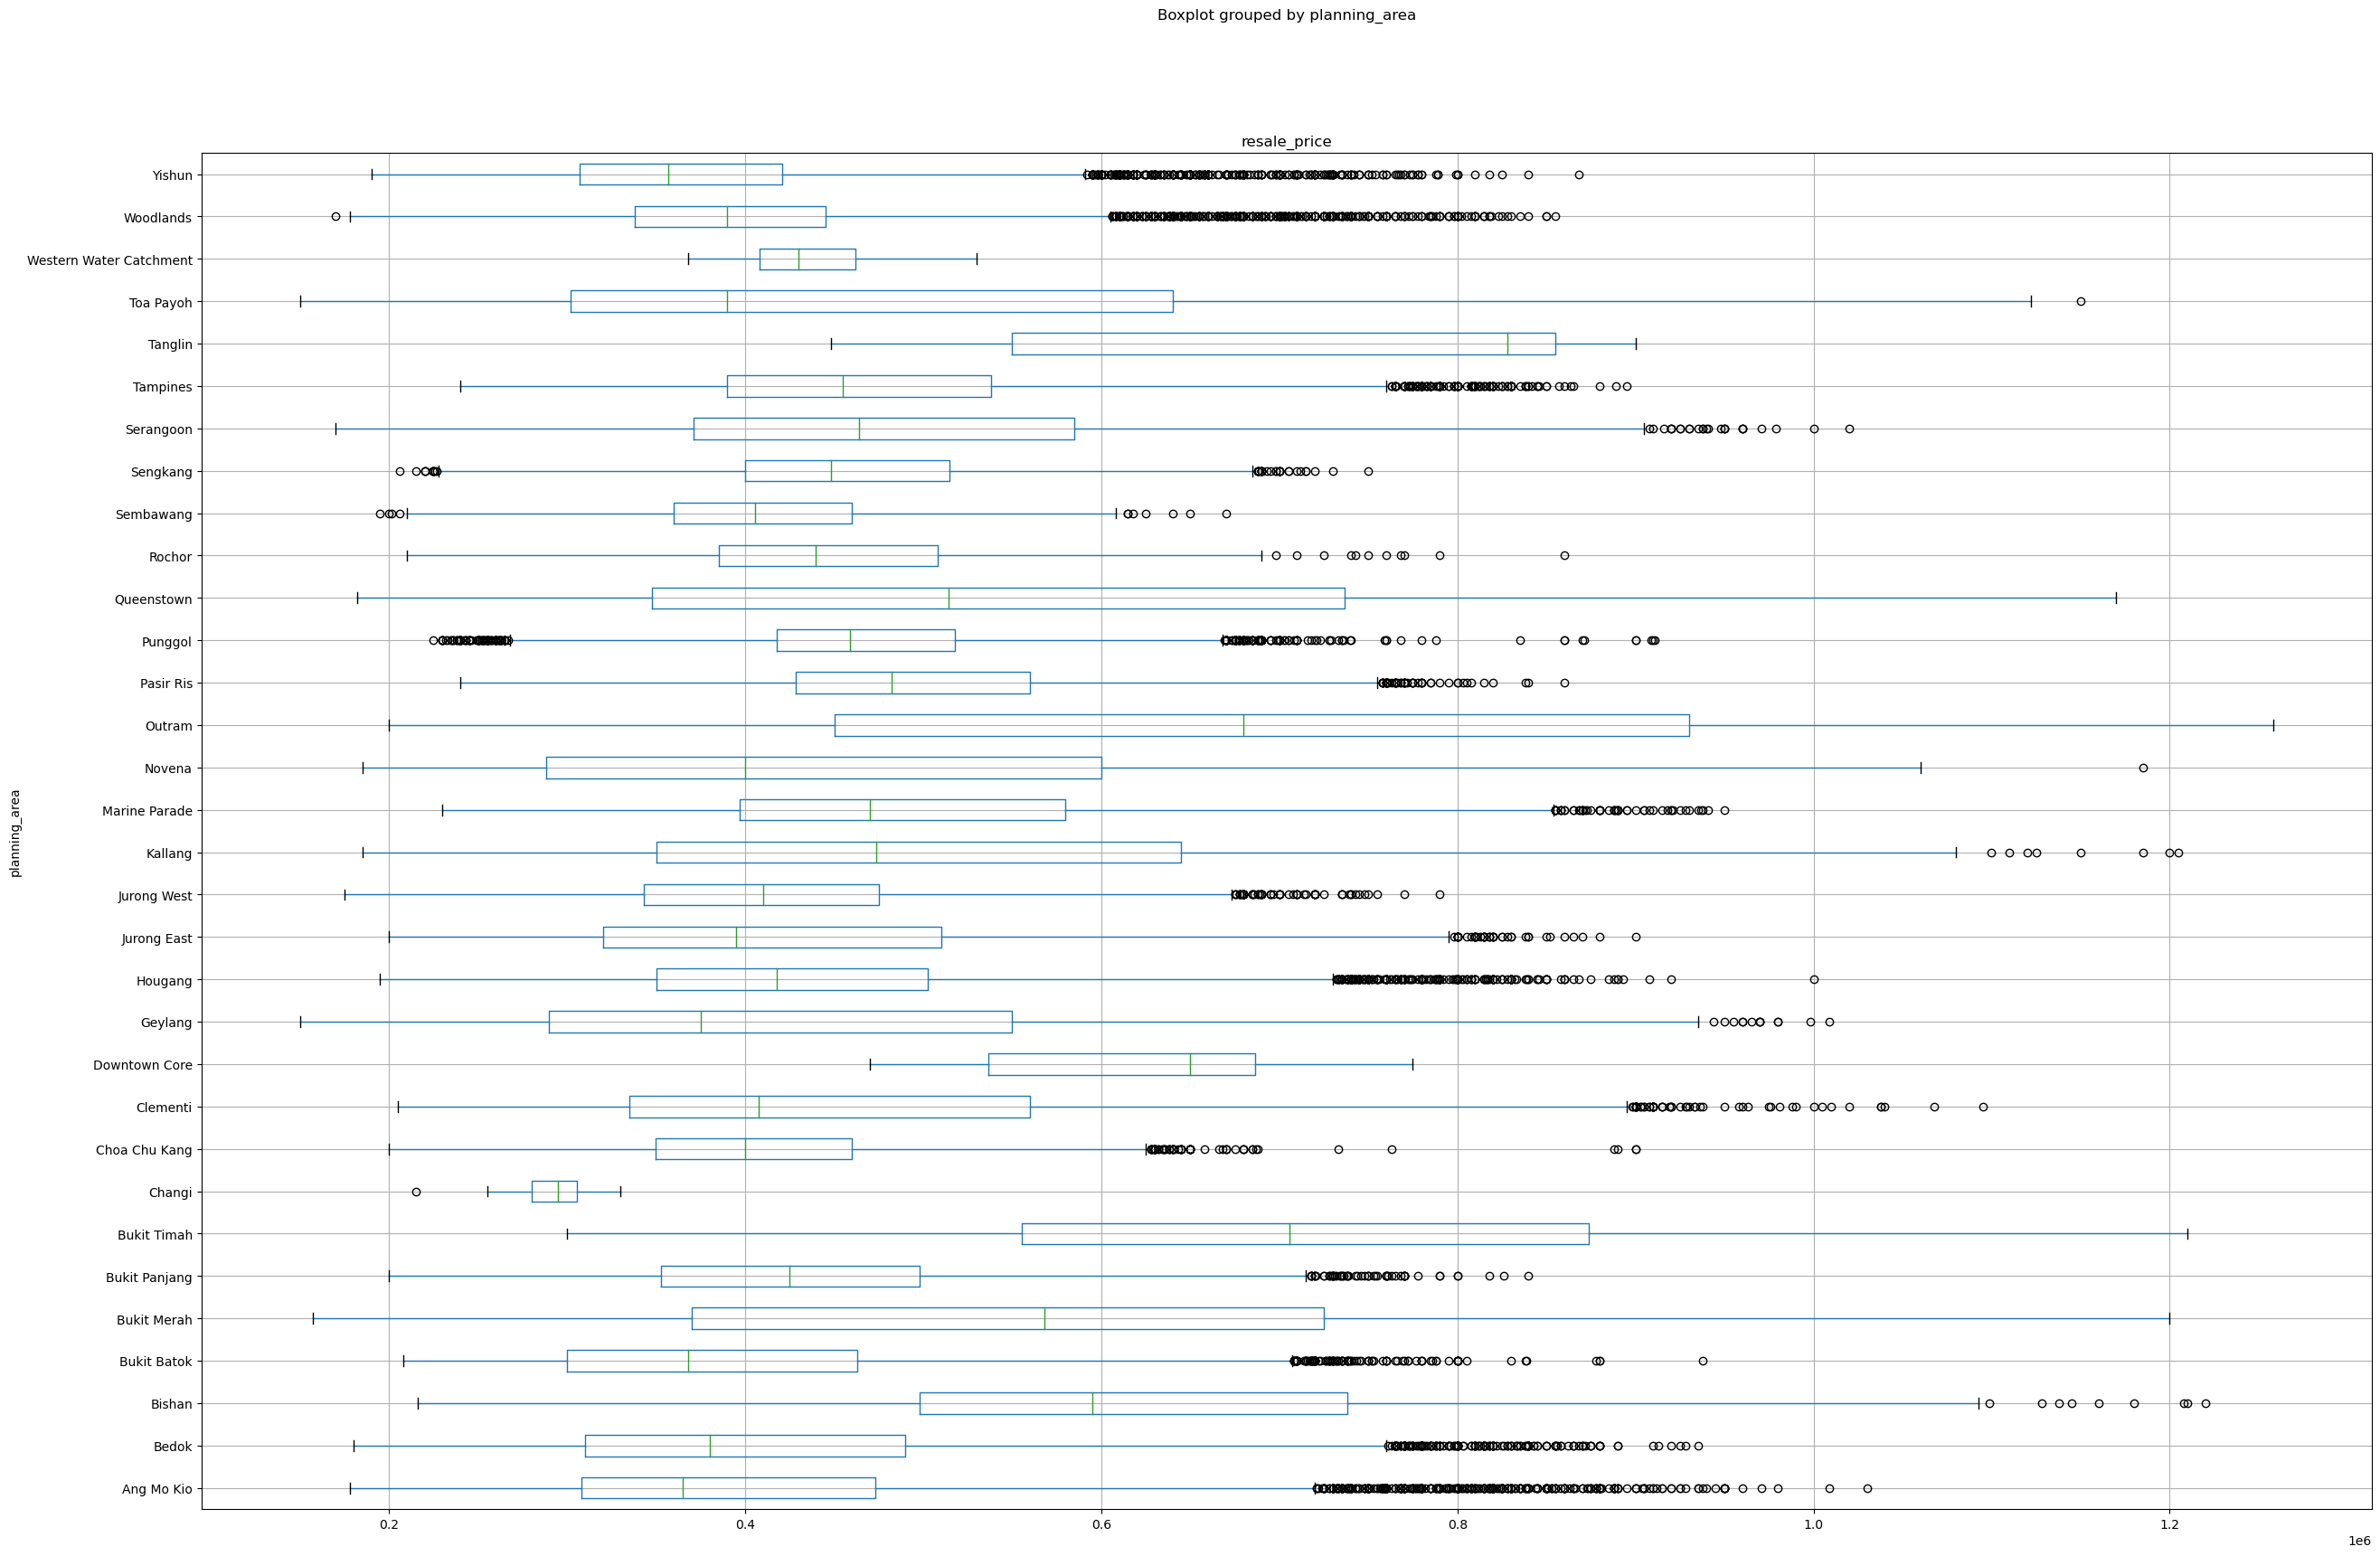

In [11]:
# Group the resale_price data by planning_area
train_df.boxplot(column='resale_price', by='planning_area', vert=False, figsize=(30,20))

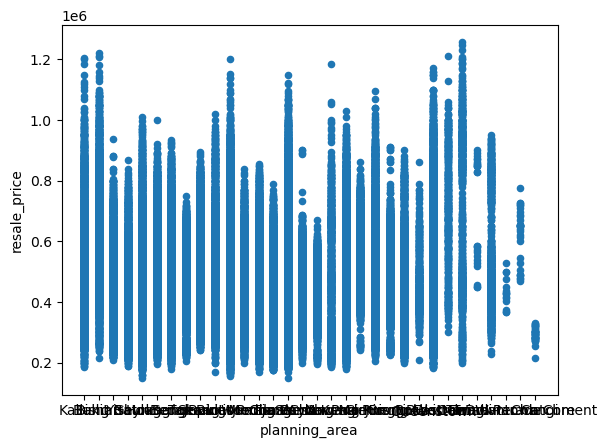

In [12]:
# Barely any correlation between planning_area and resale_price

train_df.plot(kind='scatter', x='planning_area', y='resale_price');

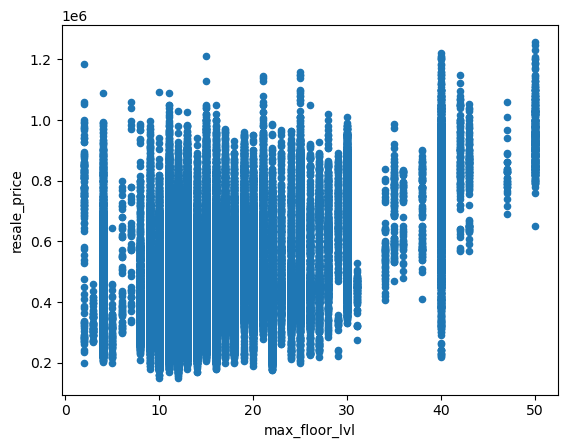

In [13]:
# Strong correlation between max_floor_lvl and price especially above level 20 (same story for mid_storey)

train_df.plot(kind='scatter', x='max_floor_lvl', y='resale_price');


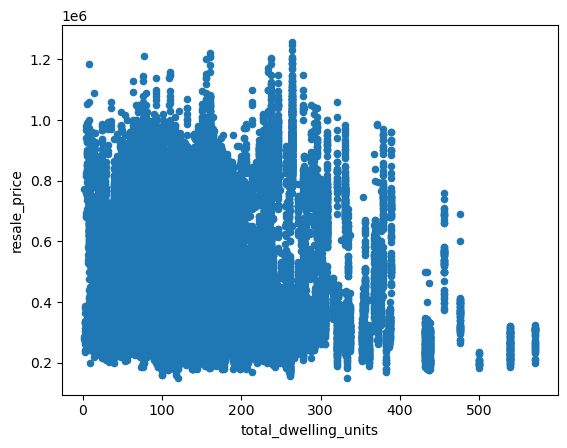

In [14]:
# Some/weak correlation between total_dwelling_units and resale_price

train_df.plot(kind='scatter', x='total_dwelling_units', y='resale_price');

In [15]:
# Check Mutual Information scores for Feature Selection

# Define function first

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name='MI Scores', index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [16]:
# Check Mutual Information scores for Feature Selection

# Encode all non-numeric categorical features to numeric types 

X = train_df.copy()
y = X.pop('resale_price')

for col in X.select_dtypes('object'):
    X[col], _ = X[col].factorize()
    
discrete_features = X.dtypes == np.int64

In [23]:
# Check Mutual Information scores for Feature Selection

# Perform MI scoring on each feature column individually (MI is a univariate metric so it is fine)

mutual_info_series = pd.Series()
count=0

for col in X.columns:
    single_X = X[[col]]
    discrete = single_X.dtypes == np.int64
    try:
        mi_score = make_mi_scores(single_X, y, discrete)
        mutual_info_series = pd.concat([mutual_info_series, mi_score])
        count +=1
        print(f'Count {count}:   {col} MI score = {mi_score.values}')
    except:
        print(f' Error at {col}')



C:\Users\leagu\AppData\Local\Temp\ipykernel_13328\4294475147.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mutual_info_series = pd.Series()


 Error at id
Count 1:   tranc_yearmonth MI score = [0.05307371]
Count 2:   town MI score = [0.18958555]
Count 3:   flat_type MI score = [0.43404836]
Count 4:   block MI score = [0.42581387]
Count 5:   street_name MI score = [0.53413041]
Count 6:   storey_range MI score = [0.07497738]
Count 7:   floor_area_sqm MI score = [0.5419217]
Count 8:   flat_model MI score = [0.28151732]
Count 9:   lease_commence_date MI score = [0.21069643]
Count 10:   tranc_year MI score = [0.05041502]
Count 11:   tranc_month MI score = [0.00409217]
Count 12:   mid_storey MI score = [0.07313855]
Count 13:   lower MI score = [0.07291261]
Count 14:   upper MI score = [0.07496287]
Count 15:   mid MI score = [0.07231441]
Count 16:   full_flat_type MI score = [0.55138156]
Count 17:   address MI score = [1.06053517]
Count 18:   floor_area_sqft MI score = [0.5438353]
Count 19:   hdb_age MI score = [0.20933384]
Count 20:   max_floor_lvl MI score = [0.19707979]
Count 21:   year_completed MI score = [0.2202986]
Count 22:

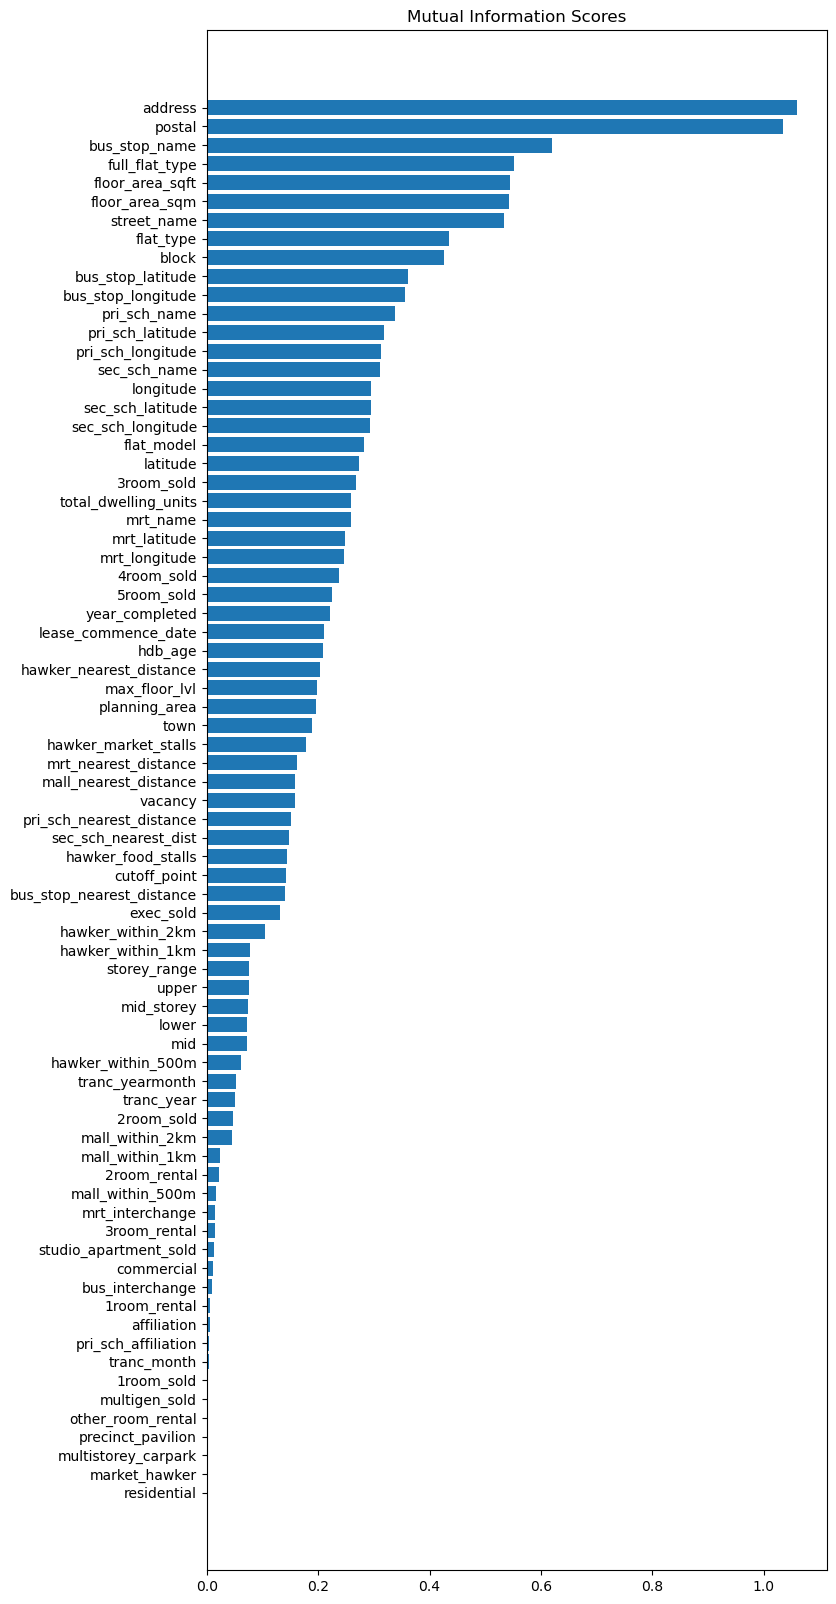

In [24]:
# Plot Mutual Information scores for each Feature 

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    

plt.figure(dpi=100, figsize=(8,20))
plot_mi_scores(mutual_info_series)

# Address, postal, bus_stop_name, full_flat_type, floor_area_sqft ranked among the most informative features in predicting resale_prices
# But this is just an independent metric which cannot account for an interaction value
# Target-encoding on some of these highly-ranked features will be required to extract more information from them.

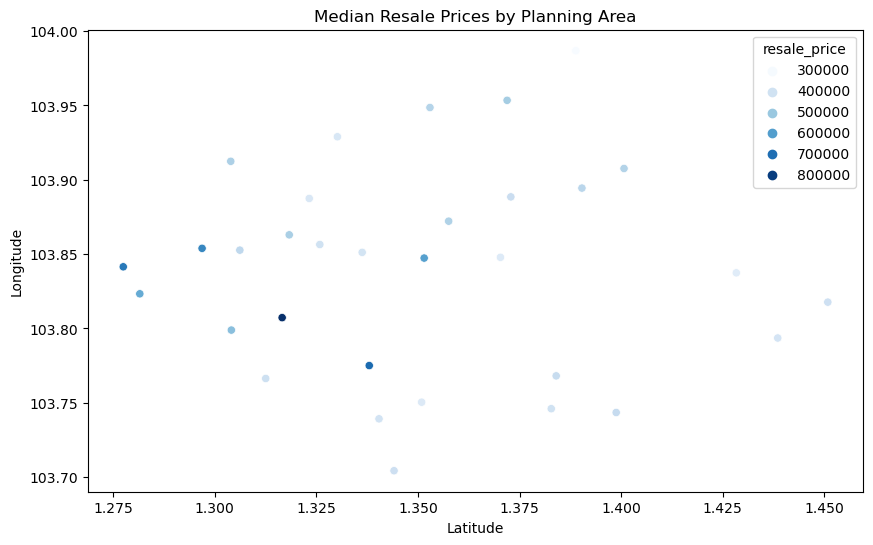

In [61]:
planning_area_mean_prices = train_df.groupby('planning_area')[['resale_price', 'Latitude', 'Longitude']].median()

plt.figure(figsize=(10, 6))
custom_color = sns.color_palette("Blues", as_cmap=True)
sns.scatterplot(x=planning_area_mean_prices['Latitude'], y=planning_area_mean_prices['Longitude'], hue=planning_area_mean_prices['resale_price'], palette=custom_color)
plt.title('Median Resale Prices by Planning Area');

# With 32 data points, we can see that houses are generally more expensive in the West

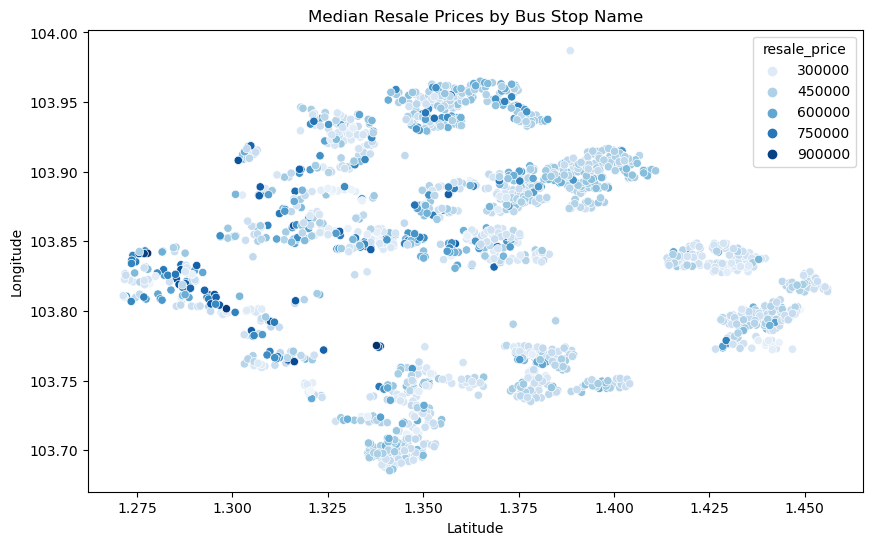

In [59]:
bus_stop_mean_prices = train_df.groupby('bus_stop_name')[['resale_price', 'Latitude', 'Longitude']].median()

plt.figure(figsize=(10, 6))
custom_color = sns.color_palette("Blues", as_cmap=True)
sns.scatterplot(x=bus_stop_mean_prices['Latitude'], y=bus_stop_mean_prices['Longitude'], hue=bus_stop_mean_prices['resale_price'], palette=custom_color)
plt.title('Median Resale Prices by Bus Stop Name');


# 1657 data points start to reveal more expensive places

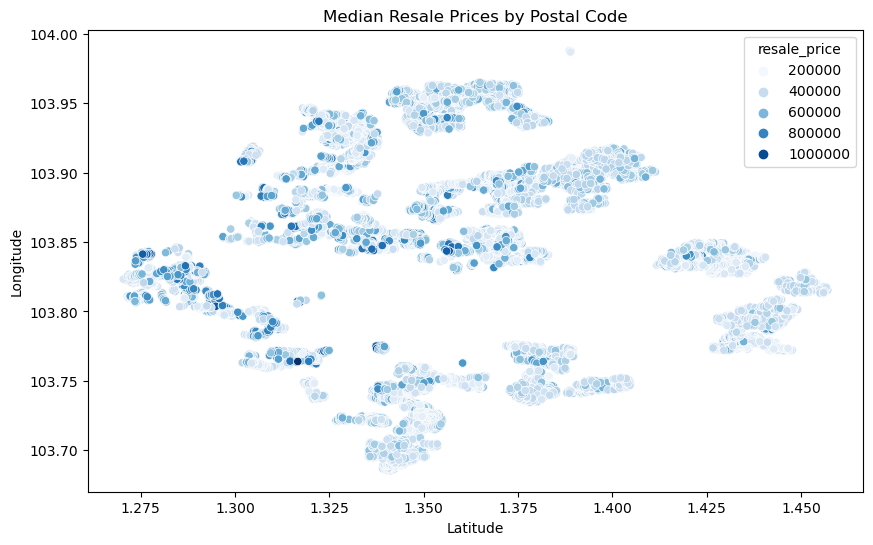

In [60]:
postal_mean_prices = train_df.groupby('postal')[['resale_price', 'Latitude', 'Longitude']].median()

plt.figure(figsize=(10, 6))
custom_color = sns.color_palette("Blues", as_cmap=True)
sns.scatterplot(x=postal_mean_prices['Latitude'], y=postal_mean_prices['Longitude'], hue=postal_mean_prices['resale_price'], palette=custom_color)
plt.title('Median Resale Prices by Postal Code');

# 17483 data points reinforces the common patterns in pricing distribution, but with greater granularity, it highlights a bigger contrast between the poor and rich. 